In [2]:
from scipy.io import loadmat
import numpy as np
from PIL import Image
from scipy.special import iv  # Bessel Function
import matplotlib.pyplot as plt

In [3]:
mat_data = loadmat("data/assignmentImageDenoising_brainMRIslice.mat")
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'brainMRIsliceNoisy', 'brainMRIsliceOrig'])


In [4]:
def save_image(data: np.ndarray, filename):
    """
    Edatatracts image data from a .mat file, normalizes it, and saves it as a PNG file.

    Parameters:
        data (np.ndarray): input data
        filename (str): Name of the file to save the image to.
    """
    data_normalized = (255 * (data - np.min(data)) / (np.max(data) - np.min(data))).astype(np.uint8)

    # Save the image
    plt.imshow(data_normalized, cmap='jet')
    plt.savefig(filename)

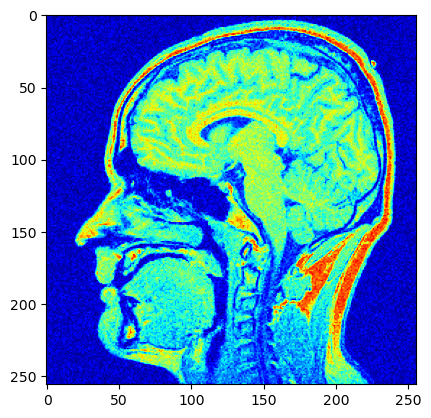

In [9]:
save_image(mat_data['brainMRIsliceOrig'], 'mri_noiseless.png')
save_image(mat_data['brainMRIsliceNoisy'], 'mri_noisy.png')

In [10]:
def RRMSE(noisy_data: np.ndarray, noiseless_data: np.ndarray) -> float:
    """
    Computes the Relative Root Mean Squared Error (RRMSE) between the noisy and noiseless data.
    """

    return np.sqrt(np.sum(np.square((noisy_data - noiseless_data)))) / np.sqrt(np.sum(np.square(noiseless_data)))


Rician Noise Model

In [11]:
def grad_rician_log_likelihood(data: np.ndarray, model: np.ndarray, beta: float) -> np.ndarray:
    """
    Compute the gradient of the Rician log likelihood.

    Parameters:
        data (np.ndarray): The observed data.
        model (np.ndarray): The model prediction.
        beta (float): Regularization parameter for the prior.

    Returns:
        np.ndarray: The gradient of the log likelihood with respect to the model.
    """
    eps = 1e-6  # Small constant to prevent division issues
    sigma = 1

    sigma_sq = sigma**2 + eps

    grad = np.zeros_like(model)

    grad += model / sigma_sq

    bessel_ratio = iv(1, np.clip((1-beta) * (data * model), -700, 700) / sigma_sq) / (iv(0, np.clip((1-beta) * (data * model) / sigma_sq, -700, 700) + eps))

    grad -= (data / sigma_sq) * bessel_ratio

    return grad


A) MRF Model with quadratic prior g(u) = |u|^2 and potential function h(u, v) = |u - v|^2


In [12]:
def grad_log_prior_quad(data: np.ndarray) -> np.ndarray:

    diff = np.zeros_like(data)
    for axis in range(data.ndim):
        diff += np.abs(data - np.roll(data, shift=-1, axis=axis))

    return diff

In [37]:
obj_quad = []
def gradient_descent_quad(data, lr=0.005, decay=0.05, max_iter=500, alpha=0.8, tol=1e-6):
    model = data.copy()
    step_size = lr
    for t in range(max_iter):
        rician = grad_rician_log_likelihood(data, model, alpha)
        grad = alpha*rician+ (1-alpha)*grad_log_prior_quad(model)
        obj_quad.append(np.sum(np.square(rician)))
        step_size /= (1 + decay)
        if step_size < tol:
            break
        model = model - step_size * grad
    return model

In [38]:
ans_quad = gradient_descent_quad(mat_data['brainMRIsliceNoisy'])
print("Denoised Image", RRMSE(ans_quad, mat_data['brainMRIsliceOrig']))
print("Original Image", RRMSE(mat_data['brainMRIsliceNoisy'], mat_data['brainMRIsliceOrig']))

Denoised Image 0.14905881465280352
Original Image 0.14242647963234373


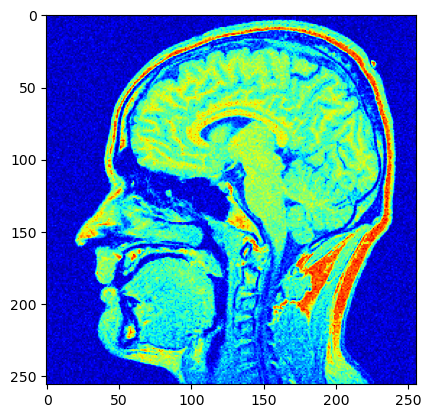

In [39]:
save_image(ans_quad, "mri_denoised_quad.png")

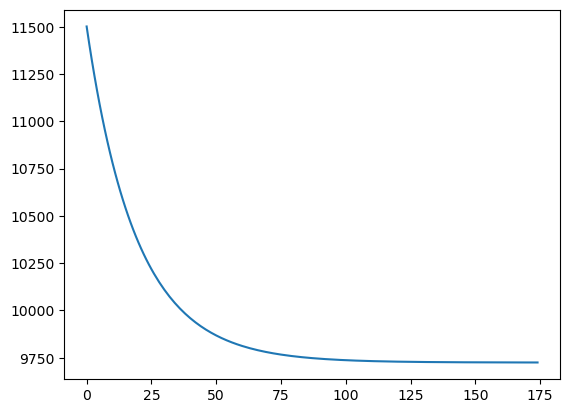

In [40]:
plt.plot(obj_quad)
plt.show()

B) MRF Model with Huber-Function: g(u) = 0.5 * u^2 if |u| <= gamma, else gamma * |u| - 0.5 * gamma ^2

In [41]:
def grad_huber(data: np.ndarray, gamma=0.1) -> np.ndarray:
    """
    Computes the gradient of the log prior using a potential function based on neighboring differences.

    Parameters:
        data (np.ndarray): Image data.
        gamma (float): Threshold value.

    Returns:
        np.ndarray: The gradient of the log prior.
    """

    diff = np.zeros_like(data)
    for axis in range(data.ndim):
        diff += np.abs(data - np.roll(data, shift=-1, axis=axis))

    mask = diff <= gamma
    return np.where(mask, diff, gamma * np.sign(diff))

In [42]:
def calc_huber(data: np.ndarray, gamma=0.1):
    diff = np.zeros_like(data)
    for axis in range(data.ndim):
        diff += np.abs(data - np.roll(data, shift=-1, axis=axis))
    mask = diff <= gamma
    return np.sum(np.square(np.where(mask, 0.5*np.square(diff), gamma * diff - 0.5 * gamma ** 2)))

In [62]:
obj_huber = []
def gradient_descent_huber(data, lr=0.005, decay=0.05, max_iter=1000, alpha = 0.8, tol=1e-5):
    step_size = lr
    model = data.copy()
    for t in range(max_iter):
        grad = (1-alpha) * (grad_rician_log_likelihood(data, model, alpha)) + alpha * grad_huber(model)
        step_size /= (1 + decay)
        if step_size < tol:
            break
        model = model - step_size * grad
        obj_huber.append(calc_huber(model))
    return model

In [63]:
ans_huber = gradient_descent_huber(mat_data['brainMRIsliceNoisy'])
print("Denoised Image", RRMSE(ans_huber, mat_data['brainMRIsliceOrig']))
print("Original Image", RRMSE(mat_data['brainMRIsliceNoisy'], mat_data['brainMRIsliceOrig']))

Denoised Image 0.13749713312864353
Original Image 0.14242647963234373


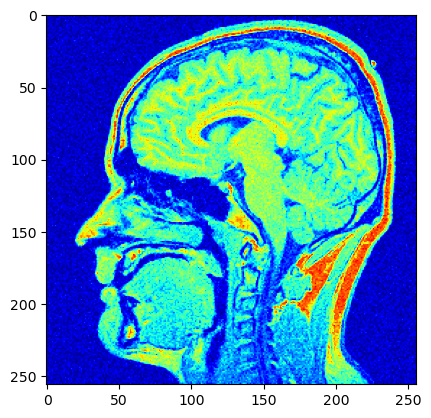

In [64]:
save_image(ans_huber, "mri_denoised_huber.png")

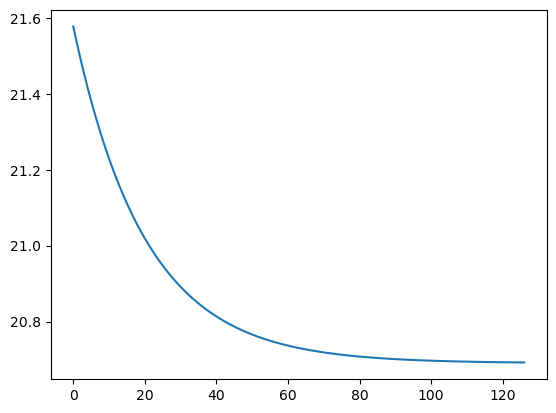

In [65]:
plt.plot(obj_huber)
plt.show()

In [102]:
def grad_discontinuity_adaptive(data: np.ndarray, gamma=0.15) -> np.ndarray:
    """
    Computes the gradient of the log prior using a potential function based on neighboring differences.

    Parameters:
        data (np.ndarray): Image data.
        gamma (float): Constant

    Returns:
        np.ndarray: The gradient of the log prior.
    """

    diff = np.zeros_like(data)
    for axis in range(data.ndim):
        diff += np.abs(data - np.roll(data, shift=-1, axis=axis))

    return gamma * np.sign(diff) - gamma*diff/(gamma+diff) * np.sign(diff)

In [103]:
def calc_adapt(data:np.ndarray, gamma=0.15) -> float:
    diff = np.zeros_like(data)
    for axis in range(data.ndim):
        diff += np.abs(data - np.roll(data, shift=-1, axis=axis))
    return np.sum(gamma * diff - gamma ** 2 * np.log(1 + diff / gamma))

In [104]:
obj_adapt = []
def gradient_descent_adapt(data, lr=0.005, decay=0.02, max_iter=1000, tol=1e-6):
    alpha = 0.95
    step_size = lr
    model = data.copy()
    for t in range(max_iter):
        grad = (1-alpha) * (grad_rician_log_likelihood(data, model, alpha)) + alpha * grad_discontinuity_adaptive(data)
        step_size /= (1 + decay)
        if step_size < 1e-6:
            break
        model = model - step_size * grad
        obj_adapt.append(calc_adapt(model))
    return model

In [105]:
ans_adapt = gradient_descent_adapt(mat_data['brainMRIsliceNoisy'])
print("Denoised Image", RRMSE(ans_adapt, mat_data['brainMRIsliceOrig']))
print("Original Image", RRMSE(mat_data['brainMRIsliceNoisy'], mat_data['brainMRIsliceOrig']))

Denoised Image 0.13627946612961794
Original Image 0.14242647963234373


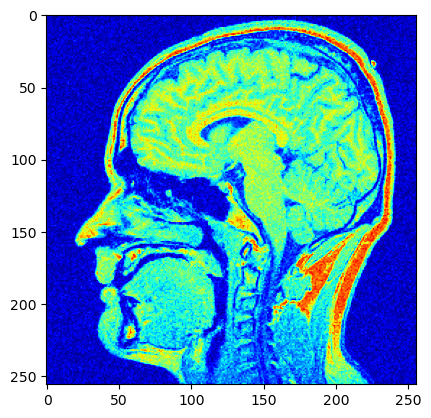

In [106]:
save_image(ans_adapt, "mri_denoised_adapt.png")


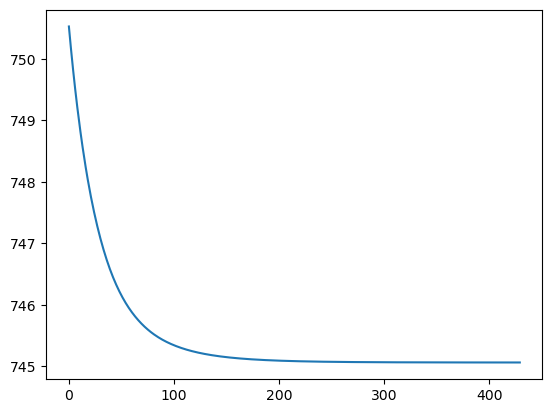

In [107]:
plt.plot(obj_adapt)
plt.show()